<a href="https://colab.research.google.com/github/rufimelo99/UltimatumGame/blob/main/UltimatumGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classes

## Player Class

In [85]:
import random
import numpy as np
import numpy.random as rnd
import math
from enum import Enum
bargainValues = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
mapValuesIndex = {0: 0, 0.05: 1, 0.1: 2, 0.15: 3, 0.2:4, 0.25: 5, 0.3: 6, 0.35: 7, 0.4: 8, 0.45: 9, 0.5: 10, 0.55: 11, 0.6: 12, 0.65: 13, 0.7: 14, 0.75: 15, 0.8: 16, 0.85: 17, 0.9: 18, 0.95: 19, 1: 20}
mapIndexValues = {0: 0, 1: 0.05, 2: 0.1, 3: 0.15, 4:0.2, 5: 0.25, 6: 0.3, 7: 0.35, 8: 0.4, 9: 0.45, 10: 5, 11: 5.5, 12: 6, 13: 6.5, 14: 7, 15: 7.5, 16: 8, 17: 8.5, 18: 9, 19: 9.5, 20: 1}

class PlayerRole(Enum):
    EMPATHIC = 1
    PRAGMATIC = 2
    INDEPENDENT = 3

class Player:
    def __init__(self, id, PlayerRole) -> None:
        self.id=id
        self.neighbours = []
        self.ComulativePayoff = 0

        self.pValue=0
        self.qValue=0
        self.PlayerRole=PlayerRole

    def attributeStrategy(self):
      if self.PlayerRole == PlayerRole.EMPATHIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = self.pValue
      elif self.PlayerRole == PlayerRole.PRAGMATIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = 1-self.pValue
      elif self.PlayerRole == PlayerRole.INDEPENDENT :
        self.pValue = random.choice(bargainValues)
        self.qValue = random.choice(bargainValues)



    def makeOffer(self):
        #returns index of bargain proposal 
        #offer from Proposer
        return mapValuesIndex[self.pValue]

    def bargainDecision(self, bargainValueIndex):
        if mapIndexValues[bargainValueIndex]>=self.qValue:
          return 1
        else:
          return 0 


## Ultimaum Game Class

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

stopsForGraphs = [1,100,1000,10000, 20000]

class ultimatumGame:
  
    def __init__(self, Nplayers, PlayerRole, ScaleFree=False) -> None:
        
        if ScaleFree:
          #Scale-Free
          #self.graph = nx.complete_graph(Nplayers)
          #ver aqui o argumento n
          self.graph = nx.barabasi_albert_graph(Nplayers, 2)
        else:
          #Erdos-Renyi
          self.graph = nx.erdos_renyi_graph(Nplayers, 0.4)

        self.Players = {}
        
        #uniforms distributions i gueess TODO
        pValuesForAll = random.choices (bargainValues,k=Nplayers)
        #if needed
        qValuesForAll = random.choices (bargainValues,k=Nplayers)

        #create all players
        for i in range(Nplayers):
            player = Player(i, PlayerRole)
            player.neighbours = list(self.graph.adj[i])

            if PlayerRole == PlayerRole.EMPATHIC :
              player.pValue = pValuesForAll[i]
              player.qValue = player.pValue
            elif PlayerRole == PlayerRole.PRAGMATIC :
              player.pValue = pValuesForAll[i]
              player.qValue = 1-player.pValue
            elif PlayerRole == PlayerRole.INDEPENDENT :
              player.pValue = pValuesForAll[i]
              player.qValue = qValuesForAll[i]


            self.Players[i]=player
        print("Network created")  

    def printGraph(self):
        #nx.draw_shell(self.graph, with_labels = True)
        #nx.draw(self.graph, with_labels = True)
        
        fig = plt.figure(figsize=(40, 40)) 
        nx.draw(self.graph, node_size=150, with_labels = True) 
        plt.axis('equal') 
        plt.show() 
        plt.show()

    def runEpisode(self, actualIteration,offersDicInitial,offerDic,stopsForGraphs, SocialPenalty=True):
      for playerId in range(len(self.Players)):

        #natural selection -> see if there is a better policy in a random j neighbour and define a probability to use j's strategy 
        player = self.Players[playerId]
        if player.neighbours!=[]:
          #see if my random neighbour has a better startegy
          randomNeighbourIndex = rnd.choice(len(player.neighbours))
          randomNeighbour = self.Players[player.neighbours[randomNeighbourIndex]]
          if randomNeighbour.ComulativePayoff > player.ComulativePayoff and actualIteration != 1:
            #see here
            #usar max
            higherDegree=np.max([len(player.neighbours),len(randomNeighbour.neighbours)])

            probUsingNeighbourStategy = round(((randomNeighbour.ComulativePayoff-player.ComulativePayoff)/ (2*higherDegree)),3)
            prob = probUsingNeighbourStategy
            usingExternalPolicy = rnd.choice([0, 1], p = [1-prob, prob])
            if usingExternalPolicy:
              player.qValue = randomNeighbour.qValue
              player.pValue = randomNeighbour.pValue

        #episode itself   -> play the game  
        for neighbourId in self.Players[playerId].neighbours:
          player = self.Players[playerId]
          neighbour = self.Players[neighbourId]
          
          playerBargainIndex=player.makeOffer()
          rewardAcceptedOrNot = neighbour.bargainDecision(playerBargainIndex)
          
          playerReward = bargainValues[-(playerBargainIndex+1)]
          neighbourReward = bargainValues[playerBargainIndex]
          
          #add payoffs to player  
          player.ComulativePayoff+=rewardAcceptedOrNot*playerReward
          neighbour.ComulativePayoff+=rewardAcceptedOrNot*neighbourReward

          #save info for graphics
          if actualIteration in stopsForGraphs:
            offersDicInitial[bargainValues[playerBargainIndex]]+=1
      

      #save data for graphs
      if actualIteration in stopsForGraphs:
        offerDic[actualIteration]=offersDicInitial.copy()
        offersDicInitial.update({}.fromkeys(offersDicInitial,0))
      

      #get the comulative payoffs after a round-robin round
      lowerPayoff = len(self.Players) #just a awful large number
      lowerPayoffId = 0
      for playerId in range(len(self.Players)):
        player = self.Players[playerId]
        if player.neighbours!=[]:
          
          #reseting payoffs of that round
          player.ComulativePayoff = 0
          #updating lowerPayoff if necessary
          if player.ComulativePayoff<lowerPayoff:
            lowerPayoff=player.ComulativePayoff
            lowerPayoffId=player.id
            
        
      #Social penalty
      #see neigbours policy->comunidaades
      if SocialPenalty:
        playerToBeRemoved = self.Players[lowerPayoffId]
        #handle its neighbours
        for i in playerToBeRemoved.neighbours:
          #update its q and p values     
          self.Players[i].attributeStrategy()

        #update q and p Values
        playerToBeRemoved.attributeStrategy()


      return offersDicInitial,offerDic
          

# Execution

## Game Creation


## Running Game

### Test

Network created
iteration: 0
iteration: 5
iteration: 10
iteration: 15
iteration: 20
iteration: 25
iteration: 30
iteration: 35
iteration: 40
iteration: 45
iteration: 50
iteration: 55
iteration: 60
iteration: 65
iteration: 70
iteration: 75
iteration: 80
iteration: 85
iteration: 90
iteration: 95
iteration: 100


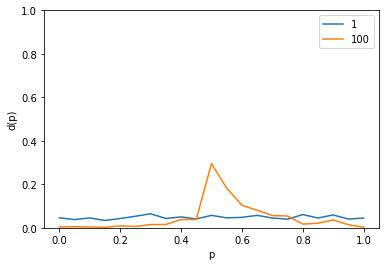

In [97]:
NPLAYERS =  1000
NITERATIONS = 101

game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=False)

offersDicInitial = mapValuesIndex.copy()
offerDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic = game.runEpisode(iteration,offersDicInitial,offerDic,stopsForGraphs, SocialPenalty=False)

plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
#plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )


# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()



# extra

In [78]:
print(np.array(list(offerDic[1].values())))
print(np.array(list(offerDic[100].values())))

#print(np.array(list(offerDic[1].values())) /sum(np.array(list(offerDic[1].values()))))
#print(np.array(list(offerDic[100].values())) /sum(np.array(list(offerDic[100].values()))))

[311 311 215 361 349 227 175 348 360 217 234 397 347 303 318 294 221 303
 316 388 173]
[300 302 200 351 334 232 180 351 344 200 219 400 347 274 312 286 224 296
 288 366 152]


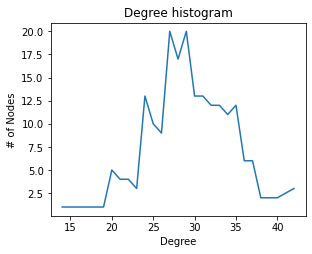

In [59]:
degree_sequence = sorted([d for n, d in game.graph.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [ ]:
for playerId in range(len(game.Players)):
  player = game.Players[playerId]
  print("player id: "+str(player.id))
  print("qinitProposer")
  print(player.qinitProposer)
  print("qinitCorrespondent")
  print(player.qinitCorrespondent)

print(list(offerDic[1].values()))

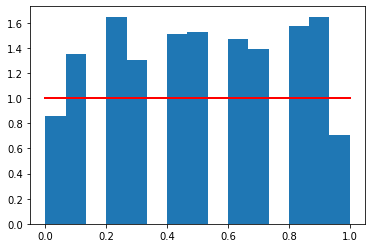

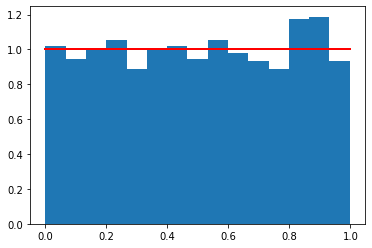

In [ ]:
s = np.random.uniform(0,1,1000)
ola = [round(i,1) for i in list(s) ]
count, bins, ignored = plt.hist(ola, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

Counter({0.3: 110, 0.5: 103, 0: 97, 0.6: 94, 1.0: 91, 0.9: 90, 0.1: 89, 0.7: 87, 0.8: 86, 0.4: 79, 0.2: 74})


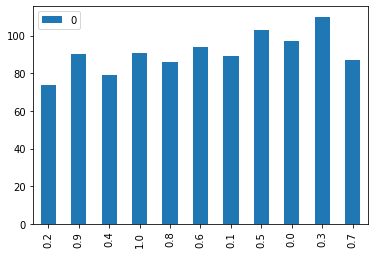

In [ ]:
from collections import Counter
import pandas
ran = random.choices (bargainValues,k=1000)
count = Counter(ran)
print(count)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')